In [1]:
from EIANN import Network
from EIANN_utils import *
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import pprint
from nested.utils import read_from_yaml, write_to_yaml

In [2]:
input_size = 21
dataset = torch.eye(input_size)
target = torch.eye(dataset.shape[0])

epochs=30
seed=42

### Gjorgjieva learning rule

In [3]:
network_config = read_from_yaml('optimize/data/20220902_EIANN_1_hidden_Gjorgieva_Hebb_config_A.yaml')
pprint.pprint(network_config)

layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

network = Network(layer_config, projection_config, seed=seed, **training_kwargs)

{'layer_config': {'H1': {'E': {'activation': 'relu', 'size': 7},
                         'FBI': {'activation': 'relu', 'size': 7}},
                  'Input': {'E': {'size': 21}},
                  'Output': {'E': {'activation': 'relu', 'size': 21},
                             'FBI': {'activation': 'relu', 'size': 7}}},
 'projection_config': {'H1': {'E': {'H1': {'FBI': {'direction': 'R',
                                                   'learning_rule': 'GjorgievaHebb',
                                                   'learning_rule_kwargs': {'learning_rate': 0.11205994529904711,
                                                                            'sign': -1},
                                                   'weight_bounds': (None, 0),
                                                   'weight_constraint': 'normalize_weight',
                                                   'weight_constraint_kwargs': {'scale': 1.301412672000941},
                                       

/Users/ag1880/Github_repos/Milstein-Lab/dentate_circuit_learning/EIANN_utils.py:152: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ag1880/Github_repos/Milstein-Lab/dentate_circuit_learning/EIANN_utils.py:191: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ag1880/Github_repos/Milstein-Lab/dentate_circuit_learning/EIANN_utils.py:223: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Initial population biases:
H1 E Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0.])
H1 FBI Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0.])
Output E Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Output FBI Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0.])


100%|██████████| 30/30 [00:01<00:00, 21.08it/s]
/Users/ag1880/Github_repos/Milstein-Lab/dentate_circuit_learning/EIANN_utils.py:275: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ag1880/Github_repos/Milstein-Lab/dentate_circuit_learning/EIANN_utils.py:283: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ag1880/Github_repos/Milstein-Lab/dentate_circuit_learning/EIANN_utils.py:152: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Users/ag1880/Github_repos/Milstein-Lab/dentate_circuit_learning/EIANN_utils.py:191: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/Use

Final population biases:
H1 E Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0.])
H1 FBI Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0.])
Output E Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Output FBI Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0.])


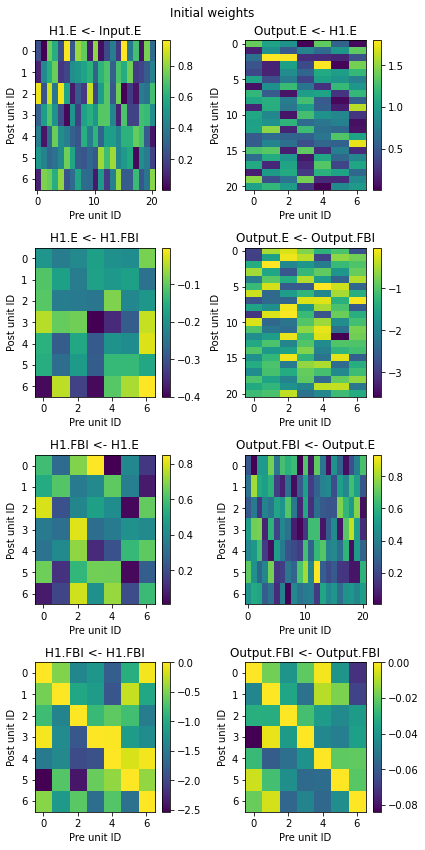

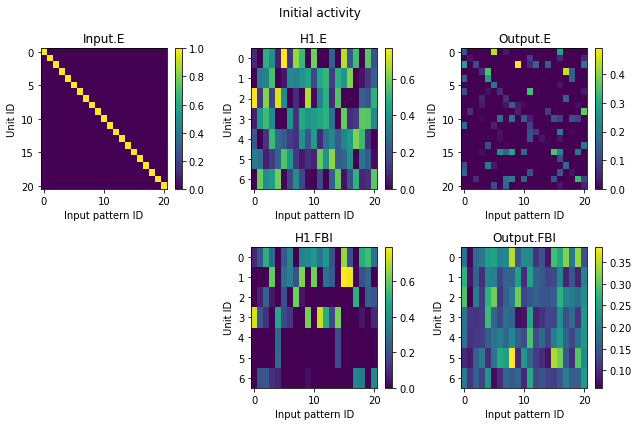

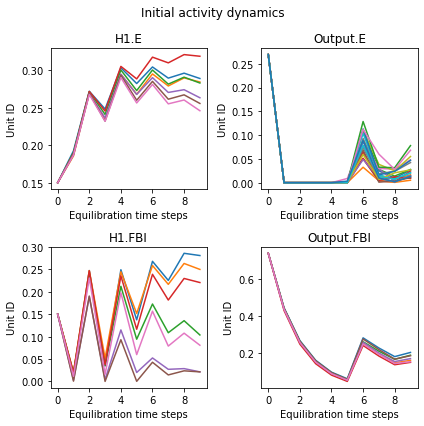

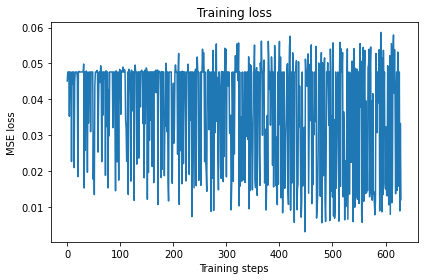

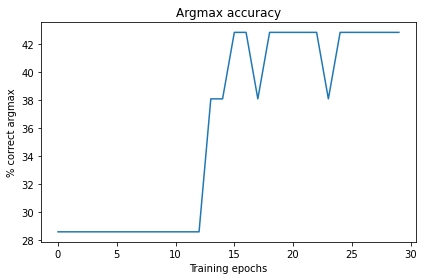

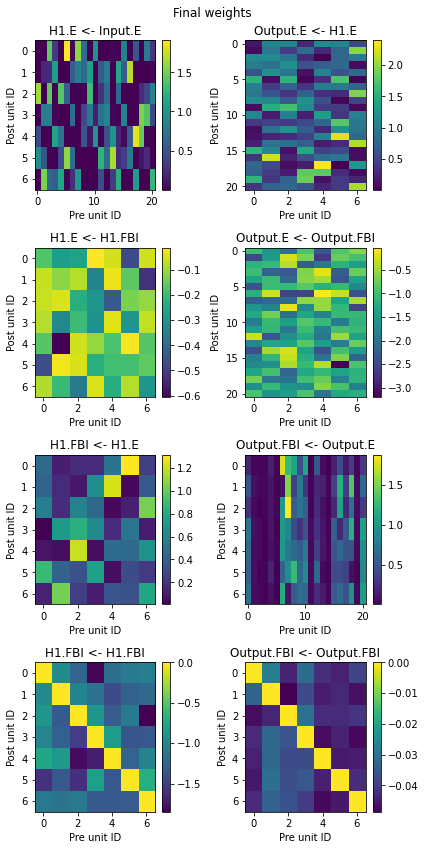

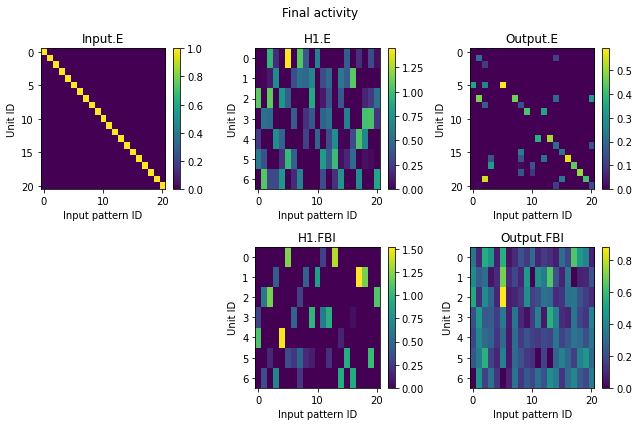

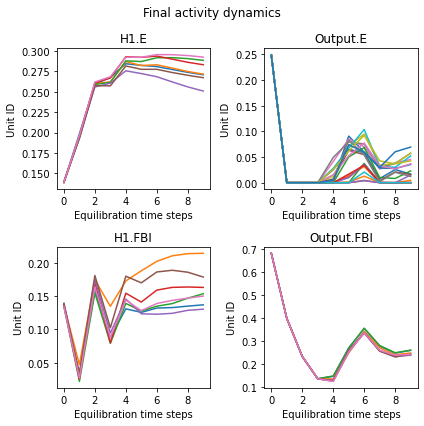

In [4]:
test_EIANN_config(network, dataset, target, epochs, supervised=False)

Pearson correlation: r=0.07333846030694384, r^2=0.0053785297601931775, p=0.37735499119170385


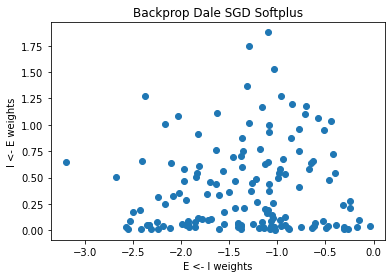

In [5]:
plt.figure()
E_I = network.Output.E.Output.FBI.weight.detach().numpy().flatten()
I_E = network.Output.FBI.Output.E.weight.detach().numpy().T.flatten()
plt.scatter(E_I, I_E)
plt.xlabel('E <- I weights')
plt.ylabel('I <- E weights')
plt.title('Backprop Dale SGD Softplus')
r, p = pearsonr(E_I, I_E)
print('Pearson correlation: r={}, r^2={}, p={}'.format(r,r**2,p))

- Export the weights along the trajectory for both models
- combine
- PCA
- interpolate (+- 10%)
- create set of weights
- probe loss of both networks
    - convert BP net to ReLU before computing loss
- plot 2D loss landscape as 3D heatmap (including 2 actual trajectories, plot separately)

In [6]:
network.forward(dataset[0])

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3623, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])

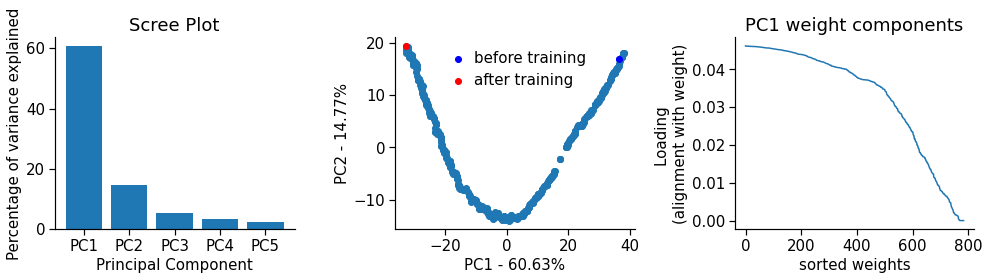

In [7]:
plt.rcParams.update({'font.size': 15,
                     'axes.spines.right': False,
                     'axes.spines.top': False,
                     'axes.linewidth':1.2,
                     'xtick.major.size': 6,
                     'xtick.major.width': 1.2,
                     'ytick.major.size': 6,
                     'ytick.major.width': 1.2,
                     'legend.frameon': False,
                     'legend.handletextpad': 0.1,
                     'figure.figsize': [14.0, 4.0],})

plot_weight_history_PCs(network)

In [8]:
ds = [x for x in zip(dataset,target)]
test_dataloader = DataLoader(ds, batch_size=1)

# plot_loss_landscape(network, test_dataloader, num_points=20)

In [ ]:
num_points = 20

flat_weight_history, weight_sizes = get_flat_weight_history(network)

# Center the data (mean=0, std=1)
w_mean = torch.mean(flat_weight_history, axis=0)
w_std = torch.std(flat_weight_history, axis=0)
centered_weight_history = (flat_weight_history - w_mean) / (w_std + 1e-10) # add epsilon to avoid NaNs

# Get weights in gridplane defined by PC dimensions
pca = PCA(n_components=2)
pca.fit(centered_weight_history)
weight_hist_pca_space = pca.transform(centered_weight_history)

PC1 = weight_hist_pca_space[:, 0]
PC2 = weight_hist_pca_space[:, 1]
range_extension = 0.1 #proportion to sample further on each side of the grid
PC1_extension = (np.max(PC1) - np.min(PC1)) * range_extension
PC2_extension = (np.max(PC2) - np.min(PC2)) * range_extension
PC1_range = np.linspace(np.min(PC1) - PC1_extension, np.max(PC1) + PC1_extension, num_points)
PC2_range = np.linspace(np.min(PC2) - PC2_extension, np.max(PC2) + PC2_extension, num_points)
PC1_mesh, PC2_mesh = np.meshgrid(PC1_range, PC2_range)

# Convert PC coordinates into full weight vectors
flat_PC1_vals = PC1_mesh.reshape(1, num_points**2)
flat_PC2_vals = PC2_mesh.reshape(1, num_points**2)
meshgrid_points = np.concatenate([flat_PC1_vals, flat_PC2_vals]).T

gridpoints_weightspace = pca.inverse_transform(meshgrid_points)
gridpoints_weightspace = torch.tensor(gridpoints_weightspace) * w_std + w_mean

# Compute loss for points in grid
losses = torch.zeros(num_points**2)
for i,gridpoint_flat in enumerate(gridpoints_weightspace):
    weight_mat_ls = unflatten_weights(gridpoint_flat, weight_sizes)
    losses[i] = compute_loss(network, weight_mat_ls, test_dataloader)
loss_grid = losses.reshape([PC1_range.size, PC2_range.size])

plot_loss_surface(loss_grid, PC1_mesh, PC2_mesh)

# Compute loss for points in weight history
loss_history = torch.zeros(flat_weight_history.shape[0])
for i,flat_weights in enumerate(flat_weight_history):
    weight_mat_ls = unflatten_weights(flat_weights, weight_sizes)
    loss_history[i] = compute_loss(network, weight_mat_ls, test_dataloader)

# # Compute loss for points in weight history
# weight_history = torch.tensor(pca.inverse_transform(weight_hist_pca_space)) * w_std + w_mean
# loss_history = torch.zeros(weight_history.shape[0])
# for i,flat_weights in enumerate(weight_history):
#     weight_mat_ls = unflatten_weights(flat_weights, weight_sizes)
#     loss_history[i] = compute_loss(network, weight_mat_ls, test_dataloader)

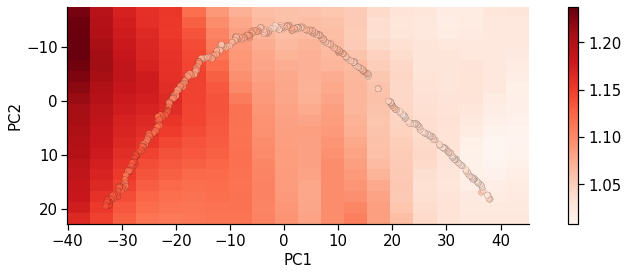

In [60]:
vmax = torch.max(torch.cat([loss_history,loss_grid.flatten()]))
vmin = torch.min(torch.cat([loss_history,loss_grid.flatten()]))

plt.imshow(loss_grid, cmap='Reds', vmax=vmax, vmin=vmin,
           extent=[np.min(PC1_range),np.max(PC1_range),np.max(PC2_range),np.min(PC2_range)])
plt.scatter(PC1,PC2, c=loss_history, cmap='Reds', edgecolors='k', linewidths=0.1, vmax=vmax, vmin=vmin)
plt.colorbar()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

### Backprop (softplus; SGD)

In [11]:
# network_config = read_from_yaml('optimize/data/20220915_EIANN_1_hidden_backprop_softplus_SGD_config.yaml')
# pprint.pprint(network_config)

# layer_config = network_config['layer_config']
# projection_config = network_config['projection_config']
# training_kwargs = network_config['training_kwargs']

# network = Network(layer_config, projection_config, seed=seed, **training_kwargs)
# test_EIANN_config(network, dataset, target, epochs, supervised=False)

In [12]:
# plt.figure()
# E_I = network.Output.E.Output.FBI.weight.detach().numpy().flatten()
# I_E = network.Output.FBI.Output.E.weight.detach().numpy().T.flatten()
# plt.scatter(E_I, I_E)
# plt.xlabel('E <- I weights')
# plt.ylabel('I <- E weights')
# plt.title('Backprop Dale SGD ReLU')
# r, p = pearsonr(E_I, I_E)
# print('Pearson correlation: r={}, r^2={}, p={}'.format(r,r**2,p))